## MINI PROJECT 1: Variant 2, Motion Correction

In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
# Useful functions to define and import datasets from open neuro
#import openneuro
#from mne.datasets import sample
#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [2]:
print("vscode")
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
# Useful imports to define the direct download function below

vscode


## Part 1: Visualizing Data

Visualise the anatomical scan and functional scan. Make an animation of the
anatomical scan and functional scan

In [2]:
dataset_id = 'ds000102'
subject = '06' 
sub = 'sub-06'

# Download one subject's data from each dataset

sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
mkdir_no_exist(bids_root)

#Derivatives folder to store masks and preprocessing garbage

mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, sub))
mkdir_no_exist(op.join(preproc_root, sub, 'anat'))
mkdir_no_exist(op.join(preproc_root, sub, 'func'))
mkdir_no_exist(op.join(preproc_root, sub, 'fmap'))

In [5]:
#Download Data
#os.system("""openneuro-py download --dataset {} --include sub-{}/anat/* 
#          --include sub-{}/func/sub-{}_task-flanker_run-1_bold.nii.gz 
#          --include sub-{}/func/sub-{}_task-flanker_run-2_bold.nii.gz 
#          --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))

In [6]:
print_dir_tree(bids_root, max_depth=3)

|ds000102/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-06/
|--- sub-06/
|------ anat/
|--------- sub-06_T1w.nii.gz
|------ func/
|--------- sub-06_task-flanker_run-1_bold.nii.gz
|--------- sub-06_task-flanker_run-2_bold.nii.gz


In [9]:
#Anatomical scan
reset_overlays()
load(op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz'))

Image(sub-06_T1w, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/anat/sub-06_T1w.nii.gz)

In [2]:
#functional scans
reset_overlays()
load(op.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-1_bold.nii.gz'))
load(op.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-2_bold.nii.gz'))

Image(sub-06_task-flanker_run-2_bold, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/func/sub-06_task-flanker_run-2_bold.nii.gz)

## Part 2: Brain extraction
Perform brain extraction on the anatomical image using FSL. Perform brain extraction for different fractional intensity threshold and comment on your observations

In [3]:
reset_overlays()
load(op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz'))

Image(sub-06_T1w, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/anat/sub-06_T1w.nii.gz)

In [18]:
anatomical_path = op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz')
fractional_intensities = np.arange(0, 5/4, 1/4)
masks = []
for fdx, fi in enumerate(fractional_intensities):
    
    betted_brain_path = op.join(preproc_root, sub, 'anat', f'sub-06_T1w_fi_{int(100*fi)}')
    masks.append(op.join(preproc_root, sub, 'anat', f'sub-06_T1w_fi_{int(100*fi)}_mask'))
    bet(anatomical_path, betted_brain_path, mask=masks[-1], robust = True, fracintensity = fi)
    
    print(f"Done {round(100*(fdx+1)/len(fractional_intensities), 1)} %") 

In [19]:
print(masks)

In [20]:
for m in masks:
    load(m + ".nii.gz")

Upon changing the fractional intensity threshold, we notice major differences in BET. 0 fractional intensity tends to take the whole volume as a mask and 1 FI fails completely at masking the gray and some white matter. The best FI's seem to be in the 0.25-0.5 range. 
**maybe hand corrections?? cringe**

### Part-3: Motion correction
1) Compute and visualize the motion parameters for 6-dof, i.e., 3 Rotations + 3 Translations across all the volumes.

In [25]:
#dont know how to get motion parameters without doing the moco in the first place bruh
runs = 2
for r in range(runs):
    path_original_data = os.path.join(bids_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold')
    path_moco_data = os.path.join(preproc_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold_moco')
    mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

In [26]:
reset_overlays()
load(path_original_data)
load(path_moco_data)

Image(sub-06_task-flanker_run-2_bold_moco, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/derivatives/preprocessed_data/sub-06/func/sub-06_task-flanker_run-2_bold_moco.nii.gz)

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002888,-0.002273,-0.000003,0.013024,-0.006096,-0.198188
1,-0.002695,-0.002344,-0.000288,0.006858,-0.006119,-0.134644
2,-0.002454,-0.002017,0.000195,-0.005998,0.017243,-0.143434
3,-0.001907,-0.002528,0.000077,0.012948,0.000076,-0.107954
4,-0.002296,-0.002641,0.000079,0.000014,0.010377,-0.104206


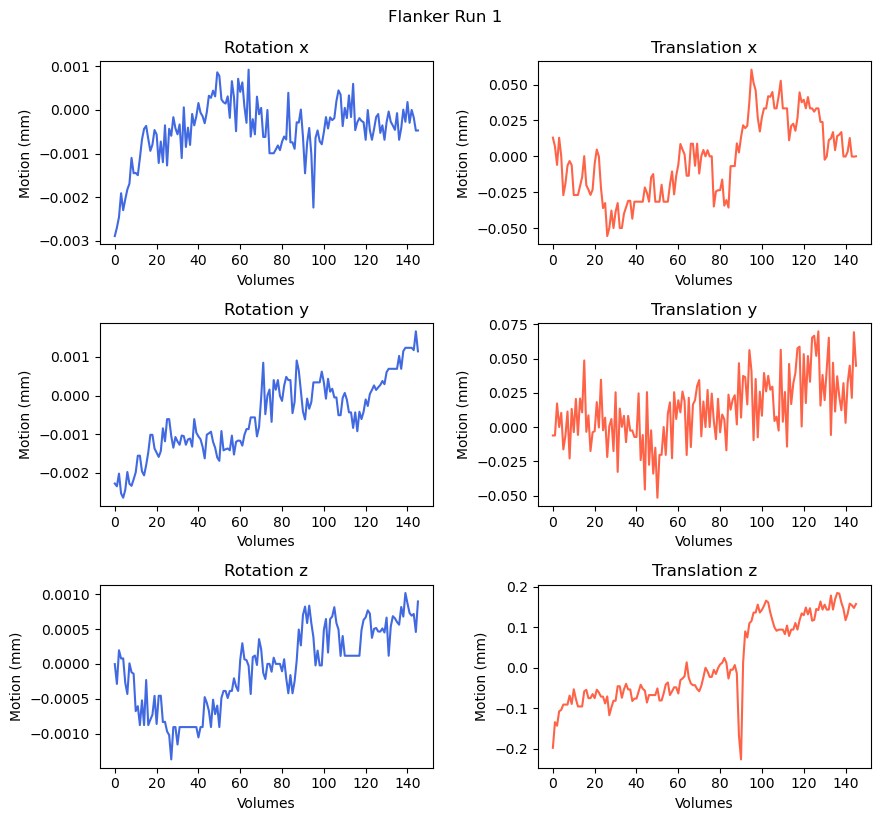

In [44]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

flanker_run = 1
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, sub, 'func', f'sub-06_task-flanker_run-{flanker_run}_bold_moco.par'))
display(mot_params.head())

%matplotlib inline

def visualize_motparams(data):
    fig, ax = plt.subplots(3, 2, figsize = (9, 8))
    for cdx, c in enumerate(data.columns.tolist()):
        ax[cdx%3, int(cdx/3)].plot(data[c], color = ["royalblue", "tomato"][int(cdx/3)])
        ax[cdx%3, int(cdx/3)].set_xlabel("Volumes")
        ax[cdx%3, int(cdx/3)].set_ylabel("Motion (mm)")
        ax[cdx%3, int(cdx/3)].set_title(c)
    plt.tight_layout()
    fig.suptitle(f"Flanker Run {flanker_run}", y = 1.02) 
    plt.show()

visualize_motparams(mot_params)

2) Compute and visualize the Framewise Displacement (FD) for all the volumes

In [45]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

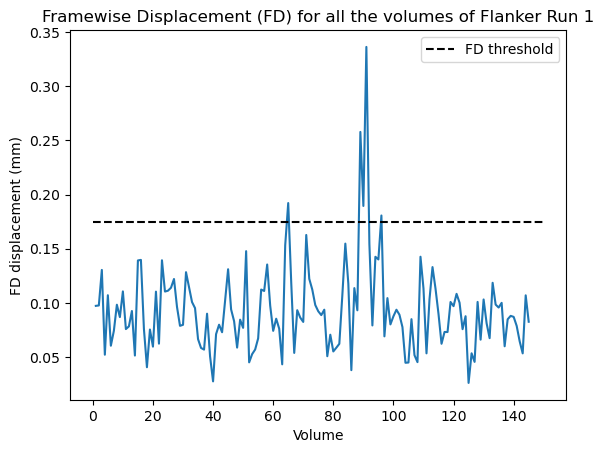

In [52]:
%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.title(f"Framewise Displacement (FD) for all the volumes of Flanker Run {flanker_run}")
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 150,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

3) Apply motion correction on your data (mcflirt settings: use default cost function,
reference volume as middle volume) and visualize the result for a volume of your
choice (other than the middle volume).

4) For original data and motion-corrected data, visualise the time series for a voxel and
report the differences you observe (if any) between the two.

5) Use a FSL command to generate a mean functional image and then use it as a
reference image for motion correction (Hint: Use -refvol flag). Pick two more subjects. Compare motion correction results (motion parameters and FD) between the 3 subjects and report your observations.